In [ ]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/Users/diol5851/Documents/rental-housing-cost/')
from notebooks.data_cleaning_EDA.AHS_Parser import AHS_Parser
sys.path.remove('/Users/diol5851/Documents/rental-housing-cost/')

In [24]:
def get_dataset(year):
    raw_dat = pd.read_feather(f'../../data/AHS_{year}.feather')
    # Drop the year column, since that does not add information here.
    dat = raw_dat.drop(columns=['YEAR'])
    # Move ADEQUACY to the first column.
    adequacy = dat.pop('ADEQUACY')
    dat.insert(0, 'ADEQUACY', adequacy)
    # Drop apartments with four or more bathrooms.
    dat = dat[dat['BATHROOMS'] < 4]
    # Drop the total housing cost column. (We want to predict RENT, so this is too related.)
    dat = dat.drop(columns=['TOTHCAMT'])
    # Parse the remaining categorical columns.
    parser = AHS_Parser()
    for col in dat.select_dtypes(include=['object']).columns:
        dat[col] = dat[col].astype('category')
        dat[col] = dat[col].cat.rename_categories(parser.parse_categorical(col, year))
        if 'Not reported' in dat[col].cat.categories:
            dat[col] = dat[col].cat.remove_categories(['Not reported'])
    return dat

In [25]:
'''Get all numeric columns from the dataset.'''
all_dat = get_dataset(2023).select_dtypes(exclude=['category'])
## Move rent to the first column. ##
# Remove the rent column from the dataset.
rent = all_dat.pop('RENT')
# Add the rent column back to the dataset.
all_dat.insert(0, 'RENT', rent)
all_dat = all_dat.replace(-6, np.nan)
all_dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22589 entries, 0 to 55667
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RENT        22589 non-null  int64  
 1   STORIES     22589 non-null  int64  
 2   YRBUILT     22589 non-null  int64  
 3   UTILAMT     22589 non-null  int64  
 4   HOAAMT      483 non-null    float64
 5   INSURAMT    19681 non-null  float64
 6   UNITFLOORS  22589 non-null  int64  
 7   BATHROOMS   22589 non-null  float64
 8   BEDROOMS    22589 non-null  int64  
 9   TOTROOMS    22589 non-null  int64  
 10  KITCHENS    22589 non-null  int64  
 11  DINING      22589 non-null  int64  
 12  LAUNDY      22589 non-null  int64  
 13  FINCP       19681 non-null  float64
 14  HINCP       19681 non-null  float64
 15  NUMNONREL   19681 non-null  float64
 16  NUMPEOPLE   19681 non-null  float64
 17  HHADLTKIDS  19681 non-null  float64
 18  HHAGE       19681 non-null  float64
 19  HHMOVE      19681 non-null  fl

In [26]:
all_dat.drop(columns=['HOAAMT']).dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
RENT,19076.0,1345.291046,1283.668084,4.0,540.0,1100.0,1800.0,13100.0
STORIES,19076.0,2.690711,1.740598,1.0,1.0,2.0,3.0,7.0
YRBUILT,19076.0,1970.515045,27.374635,1919.0,1950.0,1970.0,1990.0,2023.0
UTILAMT,19076.0,153.172153,140.500676,0.0,60.0,120.0,214.0,1460.0
INSURAMT,19076.0,12.878905,40.122217,0.0,0.0,0.0,15.0,833.0
UNITFLOORS,19076.0,1.424984,0.699060,1.0,1.0,1.0,2.0,3.0
BATHROOMS,19076.0,1.358749,0.530987,0.0,1.0,1.0,2.0,3.0
BEDROOMS,19076.0,1.959740,0.969822,0.0,1.0,2.0,3.0,5.0
TOTROOMS,19076.0,4.335186,1.361689,1.0,3.0,4.0,5.0,13.0
KITCHENS,19076.0,0.991665,0.090918,0.0,1.0,1.0,1.0,1.0


Before fitting, check the VIF for each numerical predictor.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = sm.add_constant(all_dat.drop(columns=['RENT', 'HOAAMT']).dropna())
X = X[X['HINCP'] >= 0]
pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
)

const         85692.760230
STORIES           1.237647
YRBUILT           1.185182
UTILAMT           1.536218
INSURAMT          1.035117
UNITFLOORS        1.110792
BATHROOMS         1.965515
BEDROOMS         11.023193
TOTROOMS         16.082243
KITCHENS          1.125358
DINING            3.345910
LAUNDY            1.089484
FINCP            16.145134
HINCP            16.577190
NUMNONREL         1.512039
NUMPEOPLE         1.865723
HHADLTKIDS        1.333340
HHAGE             1.419702
HHMOVE            1.252619
RATINGNH          1.046819
dtype: float64

It appears we should be dropping `TOTROOMS` and `FINCP`. We'll do that and then recheck the VIFs.

In [28]:
f_dat = all_dat.drop(columns=['TOTROOMS', 'FINCP', 'HOAAMT']).dropna()
f_dat = f_dat[f_dat['HINCP'] >= 0]
X = sm.add_constant(f_dat.drop(columns=['RENT']))
print(pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
))
f_dat['HINCP'] = f_dat['HINCP'].map(lambda x: np.log10(x + 1) if x >= 0 else np.nan)
f_dat['YRBUILT'] = f_dat['YRBUILT'].map(lambda x: x - 2000)
f_dat['HHMOVE'] = f_dat['HHMOVE'].map(lambda x: x - 2000)
f_dat['UTILAMT'] = f_dat['UTILAMT'].map(lambda x: np.log10(x + 1) if x >= 0 else np.nan)
f_dat['INSURAMT'] = f_dat['INSURAMT'].map(lambda x: np.log10(x + 1) if x >= 0 else np.nan)
X = sm.add_constant(f_dat.drop(columns=['RENT']))
f_dat.describe().T

const         85659.718584
STORIES           1.237027
YRBUILT           1.183103
UTILAMT           1.526890
INSURAMT          1.034306
UNITFLOORS        1.106861
BATHROOMS         1.938553
BEDROOMS          2.408020
KITCHENS          1.022644
DINING            1.116591
LAUNDY            1.085829
HINCP             1.117817
NUMNONREL         1.135868
NUMPEOPLE         1.857698
HHADLTKIDS        1.333098
HHAGE             1.416922
HHMOVE            1.252588
RATINGNH          1.045193
dtype: float64


,count,mean,std,min,25%,50%,75%,max
RENT,19075.0,1345.261966,1283.695450,4.0,540.000000,1100.000000,1800.000000,13100.000000
STORIES,19075.0,2.690642,1.740618,1.0,1.000000,2.000000,3.000000,7.000000
YRBUILT,19075.0,-29.487025,27.373859,-81.0,-50.000000,-30.000000,-10.000000,23.000000
UTILAMT,19075.0,1.824446,0.821328,0.0,1.785330,2.082785,2.332438,3.164650
INSURAMT,19075.0,0.560088,0.683853,0.0,0.000000,0.000000,1.204120,2.921166
UNITFLOORS,19075.0,1.424902,0.698985,1.0,1.000000,1.000000,2.000000,3.000000
BATHROOMS,19075.0,1.358716,0.530981,0.0,1.000000,1.000000,2.000000,3.000000
BEDROOMS,19075.0,1.959738,0.969847,0.0,1.000000,2.000000,3.000000,5.000000
KITCHENS,19075.0,0.991664,0.090920,0.0,1.000000,1.000000,1.000000,1.000000
DINING,19075.0,0.337877,0.496152,0.0,0.000000,0.000000,1.000000,2.000000


This looks much better. Now, let's look at the characteristics of our target variable.

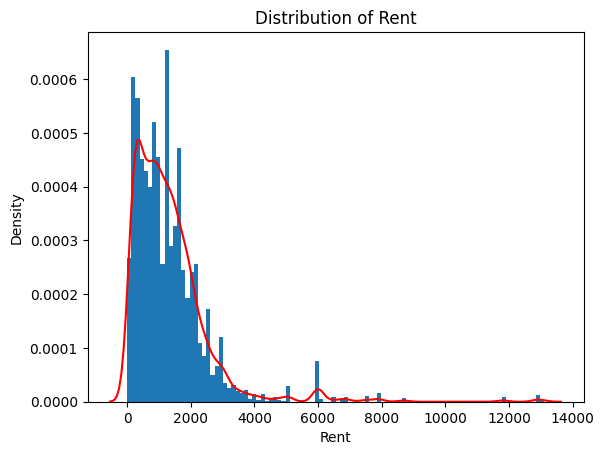

In [29]:
plt.hist(f_dat['RENT'], bins=100, density=True)
sns.kdeplot(f_dat['RENT'], color='red')
plt.xlabel('Rent')
plt.ylabel('Density')
plt.title('Distribution of Rent')
plt.show()

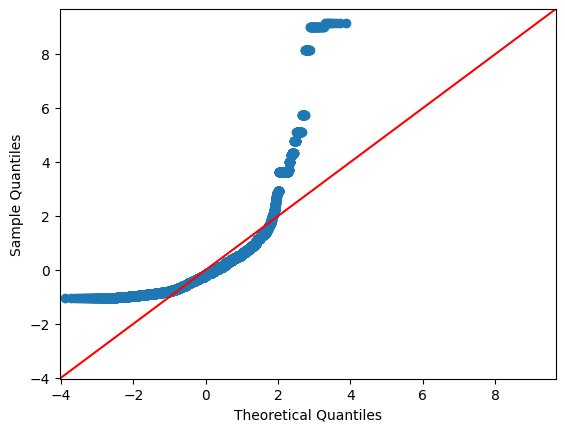

In [30]:
sm.qqplot(f_dat['RENT'], line='45', fit=True)
plt.show()

Rent is not normally distributed. Instead, it is dramatically left skewed and has very long right tails. This is not good for linear regression.

## Transform RENT, then try OLS

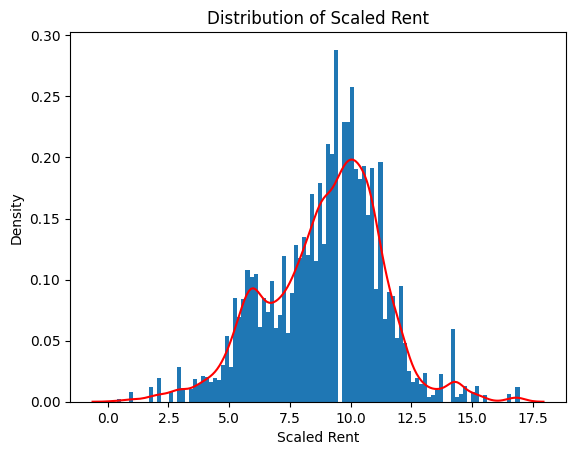

In [31]:
test_resp = np.log10(f_dat['RENT']) ** 2
plt.hist(test_resp, bins=100, density=True)
sns.kdeplot(test_resp, color='red')
plt.xlabel('Scaled Rent')
plt.ylabel('Density')
plt.title('Distribution of Scaled Rent')
plt.show()

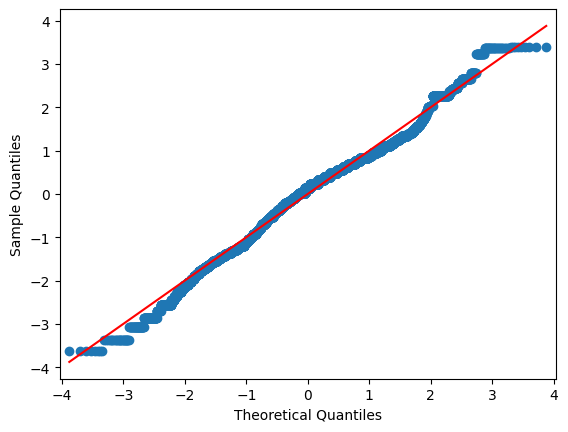

In [32]:
sm.qqplot(test_resp, line='s', fit=True)
plt.show()

In [33]:
all_var_mod = sm.OLS(
    test_resp,
    X,
    missing='raise',
).fit()
print(all_var_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   RENT   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     466.8
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:46:07   Log-Likelihood:                -40132.
No. Observations:               19075   AIC:                         8.030e+04
Df Residuals:                   19057   BIC:                         8.044e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0472      0.202     29.930      0.0

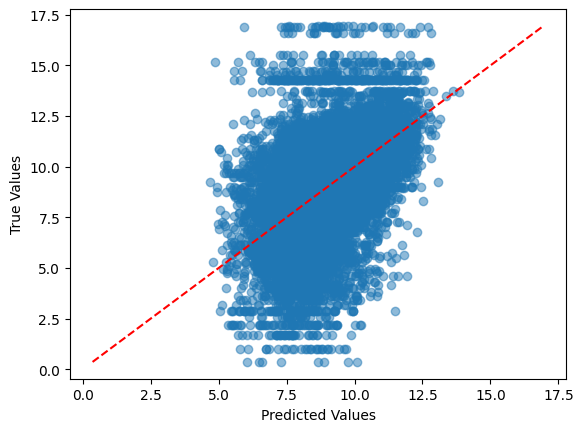

In [34]:
plt.scatter(
    all_var_mod.fittedvalues,
    test_resp,
    alpha=0.5,
)
plt.plot([np.min(test_resp), np.max(test_resp)], [np.min(test_resp), np.max(test_resp)], color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [35]:
red_mod = sm.OLS(
    test_resp,
    X.drop(columns=['YRBUILT', 'BEDROOMS']),
    missing='raise',
).fit()
print(red_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   RENT   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     529.0
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:46:07   Log-Likelihood:                -40133.
No. Observations:               19075   AIC:                         8.030e+04
Df Residuals:                   19059   BIC:                         8.042e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0554      0.200     30.343      0.0

In [36]:
sm.stats.anova_lm(red_mod, all_var_mod, robust='hc3')

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19059.0,75070.288529,0.0,NaN,NaN,NaN
1,19057.0,75064.209077,2.0,6.079452,0.771713,0.462235


### Add categorical columns.

In [37]:
## Define function to generate numeric dataset. ##
def get_num(data:pd.DataFrame):
    data = data.select_dtypes(exclude=['category'])
    data = data.replace(-6, np.nan)
    data = data.drop(columns=['TOTROOMS', 'FINCP', 'HOAAMT'])
    # Transform selected columns.
    data['HINCP'] = data['HINCP'].map(lambda x: np.log10(x + 1) if x >= 0 else np.nan)
    data['YRBUILT'] = data['YRBUILT'].map(lambda x: x - 2000)
    data['HHMOVE'] = data['HHMOVE'].map(lambda x: x - 2000)
    data['UTILAMT'] = data['UTILAMT'].map(lambda x: np.log10(x + 1) if x >= 0 else np.nan)
    data['INSURAMT'] = data['INSURAMT'].map(lambda x: np.log10(x + 1) if x >= 0 else np.nan)
    # Return dataset.
    return sm.add_constant(data)

## Define function to transform response variable. ##
def y_transform(y):
    return np.log10(y) ** 2

def back_select(data, p_sig = 0.01):
    '''Removes non-significant variables from the dataset one at a time,
    starting with the least significant variable, then refits and iterates until
    all variables are significant.

    Returns the final model.
    '''
    data = data.dropna()
    model = sm.OLS(
        y_transform(data['RENT']),
        data.drop(columns=['RENT']),
        missing='raise',
    ).fit()
    nsig = model.pvalues[model.pvalues > p_sig].sort_values(ascending = False).index.tolist()
    while len(nsig) > 0:
        if len(nsig) > 1: nsig = nsig[0]
        data = data.drop(columns=nsig)
        model = sm.OLS(
            y_transform(data['RENT']),
            data.drop(columns=['RENT']),
            missing='raise',
        ).fit()
        nsig = model.pvalues[model.pvalues > p_sig].sort_values(ascending = False).index.tolist()
    return model

In [38]:
# Check the categorical columns available.
c_dat = get_dataset(2023).select_dtypes(include=['category'])
c_dat.columns

Index(['ADEQUACY', 'OMB13CBSA', 'BLD', 'RENTCNTRL', 'RENTSUB', 'UNITSIZE',
       'GARAGE', 'PORCH', 'ACPRIMARY', 'HEATTYPE', 'HOTWATER', 'SEWTYPE',
       'WATSOURCE', 'COOKTYPE', 'FRIDGE', 'DISHWASH', 'WASHER', 'DRYER',
       'KITCHSINK', 'LEAKI', 'LEAKO', 'ROACH', 'RODENT', 'MOLDBASEM',
       'MOLDBEDRM', 'MOLDBATH', 'MOLDKITCH', 'MOLDLROOM', 'MOLDOTHER',
       'NOTOIL', 'NOWAT', 'SEWBREAK', 'FLOORHOLE', 'ROOFHOLE', 'WALLCRACK',
       'HHCITSHP', 'HHGRAD', 'HHMAR', 'HHNATVTY', 'HHRACE', 'HHSEX', 'DISHH',
       'SUBDIV', 'NEARABAND', 'NEARBARCL', 'NEARTRASH', 'NHQPCRIME',
       'NHQPUBTRN', 'NHQRISK', 'NHQSCHOOL', 'NHQSCRIME', 'HHPRNTHOME'],
      dtype='object')

In [39]:
X = get_num(get_dataset(2023))
unit_size = c_dat['UNITSIZE']
X['UNITSIZE'] = unit_size
X = pd.get_dummies(X, prefix='US', columns=['UNITSIZE'], dtype='int')
X = X.drop(columns = ['US_Less than 500 square feet'])

In [40]:
us_mod = back_select(X)
sm.stats.anova_lm(red_mod, us_mod, robust='hc3')

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19059.0,75070.288529,0.0,NaN,NaN,NaN
1,19050.0,74064.414489,9.0,1005.87404,28.746599,3.274876e-50


In [41]:
## Add location data to dataset. ##
loc = c_dat['OMB13CBSA']
#print(loc.cat.categories)
X['OMB13CBSA'] = loc
X = pd.get_dummies(X, prefix='LOC', columns=['OMB13CBSA'], dtype='int')
X = X.drop(columns=['LOC_Not in a metropolitan area'])

In [48]:
cat_mod = back_select(X)
print(f'Mod Adjusted R^2: {cat_mod.rsquared_adj:.4f}')
sm.stats.anova_lm(us_mod, cat_mod, robust='hc3')

Mod Adjusted R^2: 0.3748


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19050.0,74064.414489,0.0,NaN,NaN,NaN
1,19035.0,66342.873124,15.0,7721.541365,147.696889,0.0


In [ ]:
## Add information about near public transit. ##
trans = c_dat['NHQPUBTRN']
print(trans.cat.categories)
X['NEARTRANS'] = trans.map(lambda x: 1 if x == 'Yes' else 0)
test_mod = back_select(X)
print(f'Mod Adjusted R^2: {test_mod.rsquared_adj:.4f}')
sm.stats.anova_lm(cat_mod, test_mod, robust='hc3')

Index(['Yes', 'No', 'N/A'], dtype='object')
Mod Adjusted R^2: 0.3752


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19035.0,66342.873124,0.0,NaN,NaN,NaN
1,19035.0,66294.676268,-0.0,48.196856,-inf,NaN


In [ ]:
## Variable that NEARTRANS replaces. ##
''.join([
    c_var if c_var not in test_mod.pvalues.index.tolist() else ''
    for c_var in cat_mod.pvalues.index.tolist()
])

'NUMPEOPLE'

In [65]:
## Add building information. ##
X['BLD'] = c_dat['BLD']
X = pd.get_dummies(X, prefix='BLD', columns=['BLD'], dtype='int')
X = X.drop(columns = ['BLD_Other'])
cat_mod = test_mod
test_mod = back_select(X)
print(f'Mod Adjusted R^2: {test_mod.rsquared_adj:.4f}')
sm.stats.anova_lm(cat_mod, test_mod, robust='hc3')

Mod Adjusted R^2: 0.3763


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19035.0,66294.676268,0.0,NaN,NaN,NaN
1,19033.0,66167.585739,2.0,127.090529,18.278694,1.172947e-08


In [69]:
X['NEARSCHL'] = c_dat['NHQSCHOOL'].map(lambda x: 1 if x == 'Yes' else 0)
cat_mod = test_mod
test_mod = back_select(X)
print(f'Mod Adjusted R^2: {test_mod.rsquared_adj:.4f}')
sm.stats.anova_lm(cat_mod, test_mod, robust='hc3')

Mod Adjusted R^2: 0.3763


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19033.0,66167.585739,0.0,NaN,NaN,NaN
1,19033.0,66167.585739,-0.0,-0.0,NaN,NaN


`NEARSCHOOL` ends up not being significant. Now, we'll attempt to use forward selection to pick a model.

In [139]:
def forward_select(data:pd.DataFrame):
    data = data.dropna()
    mod_results = pd.DataFrame(columns=['Vars', 'AdjR2', 'AIC', 'BIC', 'SSE'])
    for i in range(len(data.columns) - 2):
        fit_vars = data.drop(columns = ['RENT', 'const']).columns.tolist()
        if i > 0:
            fit_vars = list(set(fit_vars).difference(mod_results['Vars'].iloc[-1]))
        # Initialize dummy vars needed for storage.
        ssr = np.inf
        b_model = None
        # Loop through variables not already selected.
        for var in fit_vars:
            if i == 0:
                model = sm.OLS(
                    y_transform(data['RENT']),
                    data[['const', var]],
                    missing='raise',
                ).fit()
                if bool(model.ssr < ssr):
                    b_model = model
                    ssr = model.ssr
            else:
                m_vars = mod_results['Vars'].iloc[-1].copy()
                m_vars.extend([var])
                model = sm.OLS(
                    y_transform(data['RENT']),
                    data[m_vars],
                    missing='raise',
                ).fit()
                if bool(model.ssr < ssr):
                    b_model = model
                    ssr = model.ssr

        # Add the best model to the results.
        mod_results = pd.concat([
            mod_results,
            pd.DataFrame({
                'Vars': [b_model.model.exog_names[:]],
                'AdjR2': b_model.rsquared_adj,
                'AIC': b_model.aic,
                'BIC': b_model.bic,
                'SSE': b_model.ssr,
            })
        ], ignore_index=True)
    
    return mod_results
        

In [157]:
r_mat = forward_select(X)

/var/folders/0c/8jgwlmw579z5xqz61k4vsvcm0000gp/T/ipykernel_96907/3531608703.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([


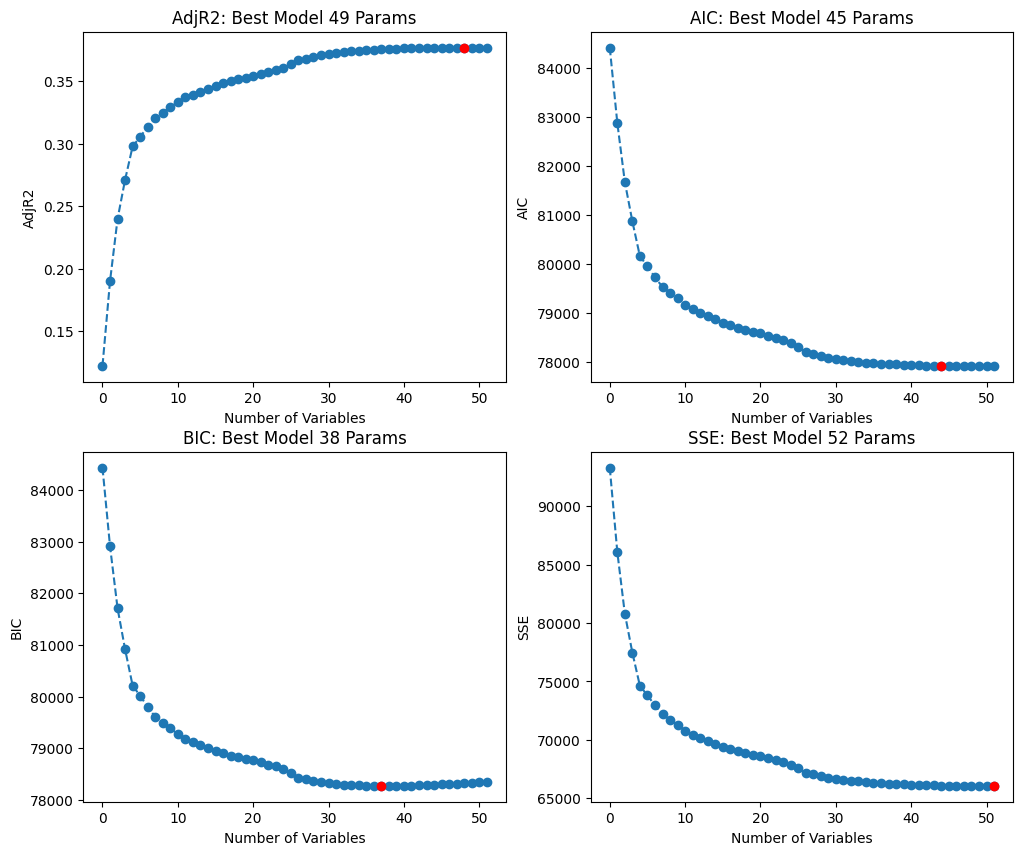

In [161]:
metrics = ['AdjR2', 'AIC', 'BIC', 'SSE']
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for axis, metric in zip(ax.flat, metrics):
    axis.plot(r_mat[metric], marker='o', linestyle='--')
    if metric == 'AdjR2':
        axis.plot(r_mat[metric].idxmax(), r_mat[metric].max(), marker='o', color='red')
        axis.set_title(f'{metric}: Best Model {r_mat[metric].idxmax() + 1} Params')
    else:
        axis.plot(r_mat[metric].idxmin(), r_mat[metric].min(), marker='o', color='red')
        axis.set_title(f'{metric}: Best Model {r_mat[metric].idxmin() + 1} Params')
    axis.set_xlabel('Number of Variables')
    axis.set_ylabel(metric)
plt.show()

In [165]:
aic_mod = sm.OLS(
    y_transform(X.dropna()['RENT']),
    X.dropna()[r_mat['Vars'].iloc[44]],
    missing='raise',
).fit()
print(aic_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   RENT   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     257.4
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:34:51   Log-Likelihood:                -38918.
No. Observations:               19075   AIC:                         7.793e+04
Df Residuals:                   19029   BIC:                         7.829e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

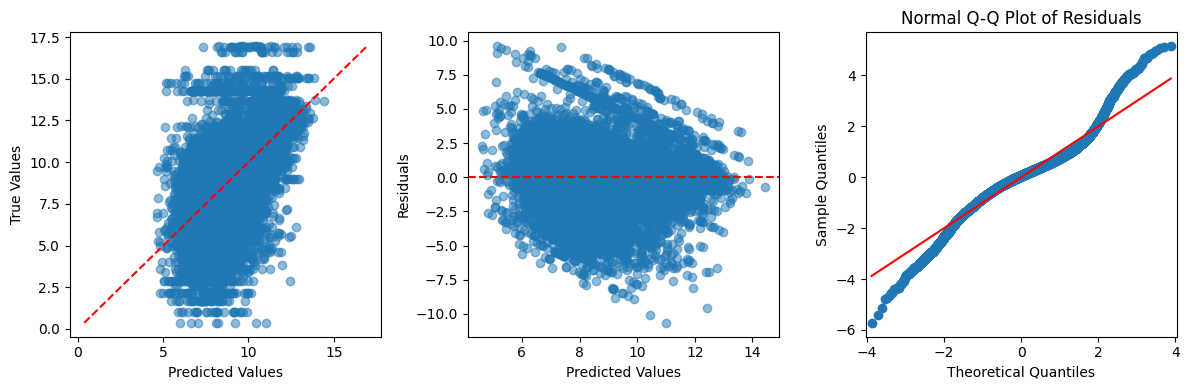

In [192]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(
    aic_mod.fittedvalues,
    y_transform(X.dropna()['RENT']),
    alpha=0.5,
)
ax[0].plot([np.min(y_transform(X.dropna()['RENT'])), np.max(y_transform(X.dropna()['RENT']))],
         [np.min(y_transform(X.dropna()['RENT'])), np.max(y_transform(X.dropna()['RENT']))], color='red', linestyle='--')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('True Values')
## Redisuals ##
ax[1].scatter(
    aic_mod.fittedvalues,
    aic_mod.resid,
    alpha=0.5,
)
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Residuals')
## QQ Plot ##
sm.qqplot(aic_mod.resid, line='s', fit=True, ax=ax[2])
ax[2].set_title('Normal Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

In [194]:
print(aic_mod.params.sort_values(ascending=False).head(11))

const                                               5.293799
LOC_San Francisco-Oakland-Hayward, CA               2.471327
LOC_Los Angeles-Long Beach-Anaheim, CA              2.325821
LOC_Miami-Fort Lauderdale-West Palm Beach, FL       2.009534
LOC_Boston-Cambridge-Newton, MA-NH                  1.984146
LOC_New York-Newark-Jersey City, NY-NJ-PA           1.812253
LOC_Seattle-Tacoma-Bellevue, WA                     1.764001
LOC_Riverside-San Bernardino-Ontario, CA            1.716985
LOC_Washington-Arlington-Alexandria, DC-VA-MD-WV    1.572177
LOC_Phoenix-Mesa-Scottsdale, AZ                     1.372536
LOC_Chicago-Naperville-Elgin, IL-IN-WI              1.303977
dtype: float64


## Compare the same model fit across years.

In [200]:
def make_data(year:int) -> pd.DataFrame:
    yr_data = get_dataset(year)
    X = get_num(yr_data)
    c_dat = yr_data.select_dtypes(include=['category'])
    # Start adding the categorical columns we selected.
    unit_size = c_dat['UNITSIZE']
    X['UNITSIZE'] = unit_size
    X = pd.get_dummies(X, prefix='US', columns=['UNITSIZE'], dtype='int')
    X = X.drop(columns = ['US_Less than 500 square feet'])
    ## Add location data to dataset. ##
    loc = c_dat['OMB13CBSA']
    X['OMB13CBSA'] = loc
    X = pd.get_dummies(X, prefix='LOC', columns=['OMB13CBSA'], dtype='int')
    X = X.drop(columns=['LOC_Not in a metropolitan area'])
    ## Add information about near public transit. ##
    trans = c_dat['NHQPUBTRN']
    X['NEARTRANS'] = trans.map(lambda x: 1 if x == 'Yes' else 0)
    ## Add building information. ##
    X['BLD'] = c_dat['BLD']
    X = pd.get_dummies(X, prefix='BLD', columns=['BLD'], dtype='int')
    X = X.drop(columns = ['BLD_Other'])
    # Schools
    X['NEARSCHL'] = c_dat['NHQSCHOOL'].map(lambda x: 1 if x == 'Yes' else 0)

    return X

def get_top_n_feats(n:int, data:pd.DataFrame, cols_to_fit:list) -> pd.DataFrame:
    mod = sm.OLS(
        y_transform(data.dropna()['RENT']),
        data.dropna()[cols_to_fit],
        missing='raise',
    ).fit()
    # Get the top n features.
    top_feats = mod.params.sort_values(ascending=False).head(n)
    return top_feats


In [203]:
years = [2021, 2019, 2017, 2015]
top_feats_yr = pd.DataFrame({2023: aic_mod.params.sort_values(ascending=False).head(11)})
for yr in years:
    yr_data = make_data(yr)
    top_feats_yr = pd.concat(
        [top_feats_yr, pd.DataFrame({yr: get_top_n_feats(11, yr_data, r_mat['Vars'].iloc[44])})],
        axis=1,
        join='outer',
    )

top_feats_yr

,2023,2021,2019,2017,2015
const,5.293799,4.675016,4.787956,3.691718,3.839127
"LOC_San Francisco-Oakland-Hayward, CA",2.471327,2.463150,2.714743,2.905342,2.535326
"LOC_Los Angeles-Long Beach-Anaheim, CA",2.325821,2.171893,2.282604,2.250389,2.067993
"LOC_Miami-Fort Lauderdale-West Palm Beach, FL",2.009534,1.647193,1.789141,1.871973,1.920288
"LOC_Boston-Cambridge-Newton, MA-NH",1.984146,1.892836,2.107246,2.052517,1.821446
"LOC_New York-Newark-Jersey City, NY-NJ-PA",1.812253,2.025933,2.187485,2.231660,1.969823
"LOC_Seattle-Tacoma-Bellevue, WA",1.764001,1.627630,1.791614,1.652155,1.432484
"LOC_Riverside-San Bernardino-Ontario, CA",1.716985,1.572012,1.587374,1.329143,1.421981
"LOC_Washington-Arlington-Alexandria, DC-VA-MD-WV",1.572177,1.756974,1.649061,1.901932,1.564711
"LOC_Phoenix-Mesa-Scottsdale, AZ",1.372536,NaN,NaN,NaN,NaN


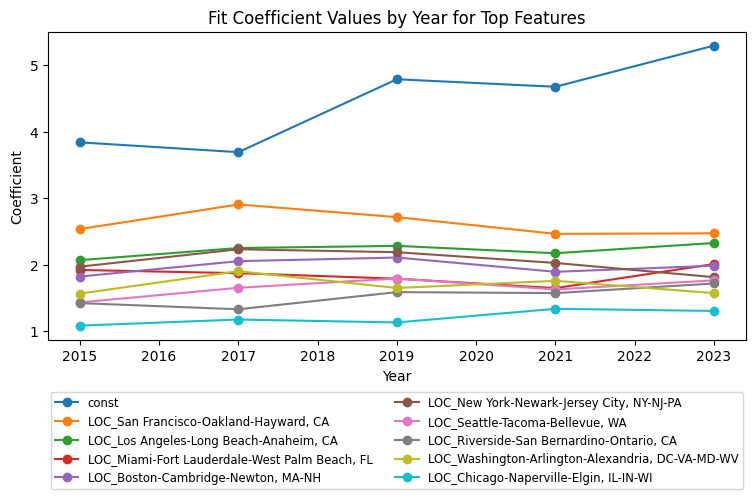

In [248]:
top_feats_yr.dropna().T.plot(
    use_index=True, 
    marker='o', 
    linestyle='-',
    legend=True,
    figsize=(9, 4),
)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    fontsize='small',
)
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Fit Coefficient Values by Year for Top Features')
plt.show()